In [ ]:
# !pip install arch

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns
# sns.set()

# import statsmodels.graphics.tsaplots as sgt # ACF and PACF
# import statsmodels.tsa.stattools as sts  # for dickey fuller test
# from arch import arch_model
# import scipy.stats as scs
import numpy as np

# from scipy.stats.distributions import chi2 # for LLR test

# import scipy.stats
# import pylab # for qq plot
# from statsmodels.stats.diagnostic import het_arch

In [ ]:
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.preprocessing import StandardScaler

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,Dropout

In [ ]:
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error

In [ ]:
from typing import Union

# Loading clean data

In [ ]:
# importing clean data
data=pd.read_feather('/content/clean_data_cols_price_lr_slr_sslr_rv_srv.feather')

In [ ]:
data.head()

,Price,log_return,scaled_log_return,realised_volatility_of_5,scaled_realised_volatility_of_5,squared_log_return
Date,,,,,,
2001-01-01,65.41,0.000000,-0.019382,0.032416,0.379606,0.000376
2001-01-02,65.41,0.000000,-0.019382,0.031055,0.363380,0.000376
2001-01-03,65.38,-0.000459,-0.053517,0.030148,0.352559,0.002864
2001-01-04,70.14,0.070277,5.209798,0.045589,0.536702,27.141995
2001-01-05,73.15,0.042019,3.107171,0.033568,0.393350,9.654515


In [ ]:
data.shape

(6310, 6)

# Preparing data

## Setting value for using past data

In [ ]:
past_data_size=23

## Function to convert data in **window** format

In [ ]:
def convert_in_windows(scaled_log_returns, scaled_realised_volatility, window_size=23):
  windowed_scaled_log_returns=np.array([])

  for i in range(window_size,len(scaled_log_returns)+1):
    for_appending = scaled_log_returns.iloc[i-window_size:i].values.reshape(1,-1)
    if windowed_scaled_log_returns.shape[0] == 0:
      windowed_scaled_log_returns = for_appending
    else:
      windowed_scaled_log_returns = np.append(windowed_scaled_log_returns,for_appending,axis=0)

  target_scaled_realised_volatility = scaled_realised_volatility.iloc[window_size:].values.reshape(-1,1)

  return windowed_scaled_log_returns, target_scaled_realised_volatility

## Extracting main columns

In [ ]:
main_data=data[['scaled_log_return','scaled_realised_volatility_of_5']]

## Convert whole data in windows

In [ ]:
windowed_data,Y=convert_in_windows(main_data['scaled_log_return'],main_data['scaled_realised_volatility_of_5'])

In [ ]:
windowed_data.shape,Y.shape

((6288, 23), (6287, 1))

# Import params of GARCH for **whole data**

In [ ]:
params_GARCH_ged=pd.read_feather('/content/params_GARCH_ged.feather')
params_GARCH_t=pd.read_feather('/content/params_GARCH_t.feather')
params_GARCH_skewt=pd.read_feather('/content/params_GARCH_skewt.feather')
params_GARCH_norm=pd.read_feather('/content/params_GARCH_norm.feather')

# Appending GARCH parameters at the end of windowed data

## **GARCH** params appended to Windowed **whole data**

In [ ]:
windowed_data_GARCH_ged_params =np.append(windowed_data,params_GARCH_ged,axis=1)
windowed_data_GARCH_t_params =np.append(windowed_data,params_GARCH_t,axis=1)
windowed_data_GARCH_skewt_params =np.append(windowed_data,params_GARCH_skewt,axis=1)
windowed_data_GARCH_norm_params =np.append(windowed_data,params_GARCH_norm,axis=1)

# all distributions combined
windowed_data_GARCH_all_dist=np.append(windowed_data,params_GARCH_ged,axis=1)
windowed_data_GARCH_all_dist=np.append(windowed_data_GARCH_all_dist,params_GARCH_t,axis=1)
windowed_data_GARCH_all_dist=np.append(windowed_data_GARCH_all_dist,params_GARCH_skewt,axis=1)
windowed_data_GARCH_all_dist=np.append(windowed_data_GARCH_all_dist,params_GARCH_norm,axis=1)

# Defining Model Architecture

In [ ]:
from tensorflow.keras.layers import Input
from tensorflow.keras.metrics import RootMeanSquaredError, MeanSquaredError, MeanAbsoluteError
from tensorflow.keras.optimizers import Adam

def get_model(X_train):

  # shape=(X_train.shape[1],1)
  input_layer = Input(shape=(X_train.shape[1],1))
  model=Sequential()
  model.add(input_layer)
  model.add(LSTM(units=64,return_sequences=True))
  model.add(Dropout(rate=0.3))
  model.add(LSTM(units=32,return_sequences=True))
  model.add(Dropout(rate=0.8))
  model.add(LSTM(units=16,return_sequences=False))
  model.add(Dropout(rate=0.8))
  model.add(Dense(units=10))
  model.add(Dense(units=1))
  model.compile(optimizer=Adam(learning_rate=0.0001),loss='MeanSquaredError')

  return model

In [ ]:
from tensorflow import keras

# Callback Functions

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True,min_delta=0.0005)

In [ ]:
windowed_data.shape,params_GARCH_ged.shape, windowed_data_GARCH_ged_params.shape

((6288, 23), (6288, 2), (6288, 25))

In [ ]:
def save_preds_actuals(tup:tuple, model_name:str, dist_name:str):

  if model_name!='GARCH' and model_name!='EGARCH':
    print('Model name should be either GARCH or EGARCH')
    return

  if dist_name not in['ged','t','skewt','norm','all_dist']:
    print('Distribution name should be either ged, t, skewt or norm')
    return

  # print()
  train_preds_actuals_df=pd.DataFrame({'train preds':np.array(tup[0]).reshape(-1),
                                       'train trues':np.array(tup[1]).reshape(-1)})

  test_preds_actuals_df=pd.DataFrame({'test preds':np.array(tup[2]).reshape(-1),
                                       'test trues':np.array(tup[3]).reshape(-1)})

  train_preds_actuals_df.to_feather(f'{model_name}_with_{dist_name}_walk_forward_train_preds_and_actuals.feather')
  test_preds_actuals_df.to_feather(f'{model_name}_with_{dist_name}_walk_forward_test_preds_and_actuals.feather')

  print('data saved!')

# Walk Forward Validation

In [ ]:
def walk_forward_validation(windowed_data_with_params,
                            Y,
                            train_fold_size=2387,
                            test_fold_size=1300):
  train_MSEs=[]
  train_MAEs=[]
  train_RMSEs=[]

  all_train_preds=[]
  all_train_trues=[]

  test_MSEs=[]
  test_MAEs=[]
  test_RMSEs=[]

  all_test_preds=[]
  all_test_trues=[]

  X=np.expand_dims(windowed_data_with_params,axis=2)[:-1] # here we are not taking last column because for last column there won't be any predictions because predictions are in new columns

  X_len=len(X)
  # print(X_len)

  for start in range(0,
                     (X_len - train_fold_size - test_fold_size) + 1, # + 1 because we want loop to run when start = 2600
                     test_fold_size):
  # print(len(x_train),len(x_val))
  #   print(x_val[-1])
    print(f'train-> {start} : {start + train_fold_size}, test-> {start + train_fold_size} : {start + train_fold_size + test_fold_size}' )

  for start in range(0,
                     (X_len - train_fold_size - test_fold_size) + 1,
                     test_fold_size):
    X_train, X_test = X[start : (start + train_fold_size)], X[(start + train_fold_size) : (start + train_fold_size + test_fold_size)]
    Y_train, Y_test = Y[start : (start + train_fold_size)], Y[(start + train_fold_size) : (start + train_fold_size + test_fold_size)]


    val_data_size=int(X_train.shape[0]*0.2)
    x_train,x_val=X_train[:-val_data_size],X_train[-val_data_size:]
    y_train,y_val=Y_train[:-val_data_size],Y_train[-val_data_size:]

    model=get_model(x_train)
    model_fit=model.fit(x_train,
                        y_train,
                        validation_data=(x_val,y_val),
                        batch_size=20,
                        epochs=150,
                        callbacks=[early_stopping],
                        verbose=False)



    # for train dataX
    train_preds=model.predict(_train)
    # train_trues=(Y_train)

    all_train_preds.extend(train_preds)
    all_train_trues.extend(Y_train)

    curr_train_MSE=mean_squared_error(Y_train,train_preds)
    curr_train_MAE=mean_absolute_error(Y_train,train_preds)
    curr_train_RMSE=root_mean_squared_error(Y_train,train_preds)

    train_MSEs.append(curr_train_MSE)
    train_MAEs.append(curr_train_MAE)
    train_RMSEs.append(curr_train_RMSE)

    # For test data
    test_preds=model.predict(X_test)
    # test_trues=(y_test)

    all_test_preds.extend(test_preds)
    all_test_trues.extend(Y_test)

    curr_test_MSE=mean_squared_error(Y_test,test_preds)
    curr_test_MAE=mean_absolute_error(Y_test,test_preds)
    curr_test_RMSE=root_mean_squared_error(Y_test,test_preds)

    test_MSEs.append(curr_test_MSE)
    test_MAEs.append(curr_test_MAE)
    test_RMSEs.append(curr_test_RMSE)




  return {'train_MSE':train_MSEs,'train_MAE':train_MAEs,'train_RMSE':train_RMSEs,'test_MSE':test_MSEs, 'test_MAE':test_MAEs, 'test_RMSE':test_RMSEs}, (all_train_preds, all_train_trues, all_test_preds, all_test_trues)



# Model : (GARCH + GED) + LSTM

In [ ]:
GARCH_ged_metric, GARCH_ged_preds_actuals=walk_forward_validation(windowed_data_GARCH_ged_params,Y)

train-> 0 : 2387, test-> 2387 : 3687
train-> 1300 : 3687, test-> 3687 : 4987
train-> 2600 : 4987, test-> 4987 : 6287
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


## Save train test preds and actuals

In [ ]:
save_preds_actuals(tup=GARCH_ged_preds_actuals,
                   model_name='GARCH',
                   dist_name='ged')

data saved!


In [ ]:
print('Train:')
print(GARCH_ged_metric['train_MSE'])
print('Mean of MSEs : ',np.array(GARCH_ged_metric['train_MSE']).mean())
print('------------------------------------------------------------------')
print('Test:')
print(GARCH_ged_metric['test_MSE'])
print('Mean of MSEs : ',np.array(GARCH_ged_metric['test_MSE']).mean())

Train:
[0.007183820113519353, 0.008493725658231154, 0.00308605299226993]
Mean of MSEs :  0.006254532921340146
------------------------------------------------------------------
Test:
[0.0042522618001228675, 0.00220221062377974, 0.006949658924449517]
Mean of MSEs :  0.004468043782784041


In [ ]:
print('Train')
print(GARCH_ged_metric['train_MAE'])
print('Mean of MAEs : ',np.array(GARCH_ged_metric['train_MAE']).mean())
print('------------------------------------------------------------------')
print('Test')
print(GARCH_ged_metric['test_MAE'])
print('Mean of MAEs : ',np.array(GARCH_ged_metric['test_MAE']).mean())

Train
[0.06049333967041791, 0.05762782892719576, 0.03756078448287082]
Mean of MAEs :  0.051893984360161495
------------------------------------------------------------------
Test
[0.0549651658483023, 0.03861790753815247, 0.05108151213267712]
Mean of MAEs :  0.048221528506377294


In [ ]:
print('Train')
print(GARCH_ged_metric['train_RMSE'])
print('Mean of RMSEs : ',np.array(GARCH_ged_metric['train_RMSE']).mean())
print('------------------------------------------------------------------')
print('Test')
print(GARCH_ged_metric['test_RMSE'])
print('Mean of RMSEs : ',np.array(GARCH_ged_metric['test_RMSE']).mean())

Train
[0.08475741922403816, 0.09216141089540217, 0.05555225461014098]
Mean of RMSEs :  0.0774903615765271
------------------------------------------------------------------
Test
[0.06520936895970446, 0.046927717010096924, 0.08336461434235462]
Mean of RMSEs :  0.06516723343738533


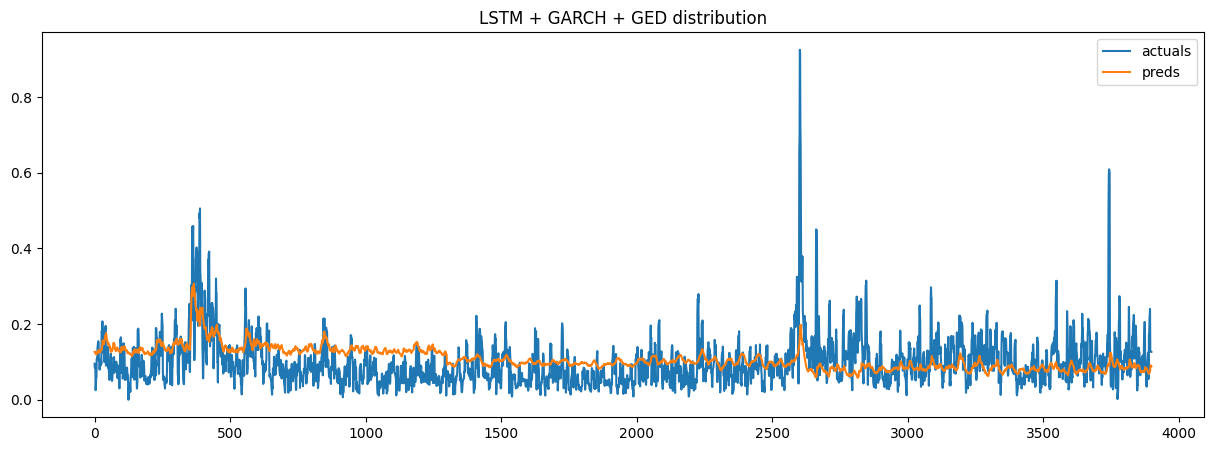

In [ ]:
all_test_preds=GARCH_ged_preds_actuals[2]
all_test_actuals=GARCH_ged_preds_actuals[3]

plt.figure(figsize=(15,5))
plt.plot(all_test_actuals,label='actuals')
plt.plot(all_test_preds,label='preds')
plt.legend()
plt.title('LSTM + GARCH + GED distribution')
plt.show()

# Model : (GARCH + t) + LSTM

In [ ]:
GARCH_t_metric, GARCH_t_preds_actuals=walk_forward_validation(windowed_data_GARCH_t_params,Y)

train-> 0 : 2387, test-> 2387 : 3687
train-> 1300 : 3687, test-> 3687 : 4987
train-> 2600 : 4987, test-> 4987 : 6287
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


## saving train, test preds and actuals

In [ ]:
save_preds_actuals(tup=GARCH_t_preds_actuals,
                   model_name='GARCH',
                   dist_name='t')

data saved!


In [ ]:
print('Train')
print(GARCH_t_metric['train_MSE'])
print('Mean of MSEs : ',np.array(GARCH_t_metric['train_MSE']).mean())
print('------------------------------------------------------------------')
print('Test')
print(GARCH_t_metric['test_MSE'])
print('Mean of MSEs : ',np.array(GARCH_t_metric['test_MSE']).mean())

Train
[0.007330204465117903, 0.007581605627613408, 0.0024784985266664973]
Mean of MSEs :  0.005796769539799269
------------------------------------------------------------------
Test
[0.004195530717309104, 0.0022100592285494575, 0.005885971104528801]
Mean of MSEs :  0.004097187016795787


In [ ]:
print('Train')
print(GARCH_t_metric['train_MAE'])
print('Mean of MAEs : ',np.array(GARCH_t_metric['train_MAE']).mean())
print('------------------------------------------------------------------')
print('Test')
print(GARCH_t_metric['test_MAE'])
print('Mean of MAEs : ',np.array(GARCH_t_metric['test_MAE']).mean())

Train
[0.06080745885316949, 0.05558129944372725, 0.035689146680568745]
Mean of MAEs :  0.050692634992488494
------------------------------------------------------------------
Test
[0.05426862743769758, 0.03892655942594991, 0.046788158624620255]
Mean of MAEs :  0.046661115162755916


In [ ]:
print('Train')
print(GARCH_t_metric['train_RMSE'])
print('Mean of RMSEs : ',np.array(GARCH_t_metric['train_RMSE']).mean())
print('------------------------------------------------------------------')
print('Test')
print(GARCH_t_metric['test_RMSE'])
print('Mean of RMSEs : ',np.array(GARCH_t_metric['test_RMSE']).mean())

Train
[0.0856166132541921, 0.08707241599733757, 0.049784520954474366]
Mean of RMSEs :  0.07415785006866801
------------------------------------------------------------------
Test
[0.06477291654163107, 0.04701126703833303, 0.07672008279797932]
Mean of RMSEs :  0.06283475545931448


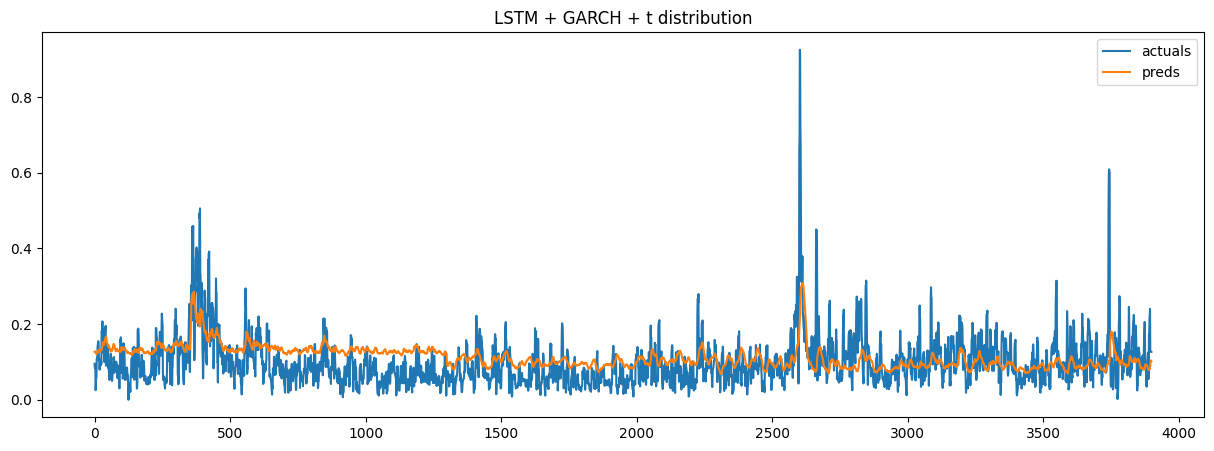

In [ ]:
all_test_preds=GARCH_t_preds_actuals[2]
all_test_actuals=GARCH_t_preds_actuals[3]

plt.figure(figsize=(15,5))
plt.plot(all_test_actuals,label='actuals')
plt.plot(all_test_preds,label='preds')
plt.legend()
plt.title('LSTM + GARCH + t distribution')
plt.show()

# Model : (GARCH + skewt) + LSTM

In [ ]:
GARCH_skewt_metric, GARCH_skewt_preds_actuals=walk_forward_validation(windowed_data_GARCH_skewt_params,Y)

train-> 0 : 2387, test-> 2387 : 3687
train-> 1300 : 3687, test-> 3687 : 4987
train-> 2600 : 4987, test-> 4987 : 6287
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


In [ ]:
save_preds_actuals(tup=GARCH_skewt_preds_actuals,
                   model_name='GARCH',
                   dist_name='skewt')

data saved!


In [ ]:
print('Train')
print(GARCH_skewt_metric['train_MSE'])
print('Mean of MSEs : ',np.array(GARCH_skewt_metric['train_MSE']).mean())
print('------------------------------------------------------------------')
print('Test')
print(GARCH_skewt_metric['test_MSE'])
print('Mean of MSEs : ',np.array(GARCH_skewt_metric['test_MSE']).mean())

Train
[0.00737241591039143, 0.007831345219824195, 0.0024193499759868346]
Mean of MSEs :  0.005874370368734154
------------------------------------------------------------------
Test
[0.004620518428346885, 0.001810229675993931, 0.005837036912472319]
Mean of MSEs :  0.0040892616722710455


In [ ]:
print('Train')
print(GARCH_skewt_metric['train_MAE'])
print('Mean of MAEs : ',np.array(GARCH_skewt_metric['train_MAE']).mean())
print('------------------------------------------------------------------')
print('Test')
print(GARCH_skewt_metric['test_MAE'])
print('Mean of MAEs : ',np.array(GARCH_skewt_metric['test_MAE']).mean())

Train
[0.06158614692146451, 0.05576018445266576, 0.03535313232111967]
Mean of MAEs :  0.050899821231749985
------------------------------------------------------------------
Test
[0.05761171449487257, 0.03383777794434211, 0.04683438931131273]
Mean of MAEs :  0.0460946272501758


In [ ]:
print('Train')
print(GARCH_skewt_metric['train_RMSE'])
print('Mean of RMSEs : ',np.array(GARCH_skewt_metric['train_RMSE']).mean())
print('------------------------------------------------------------------')
print('Test')
print(GARCH_skewt_metric['test_RMSE'])
print('Mean of RMSEs : ',np.array(GARCH_skewt_metric['test_RMSE']).mean())

Train
[0.0858627737170855, 0.0884948880999586, 0.04918688825273291]
Mean of RMSEs :  0.074514850023259
------------------------------------------------------------------
Test
[0.06797439538787296, 0.04254679395670056, 0.0764005033522183]
Mean of RMSEs :  0.06230723089893061


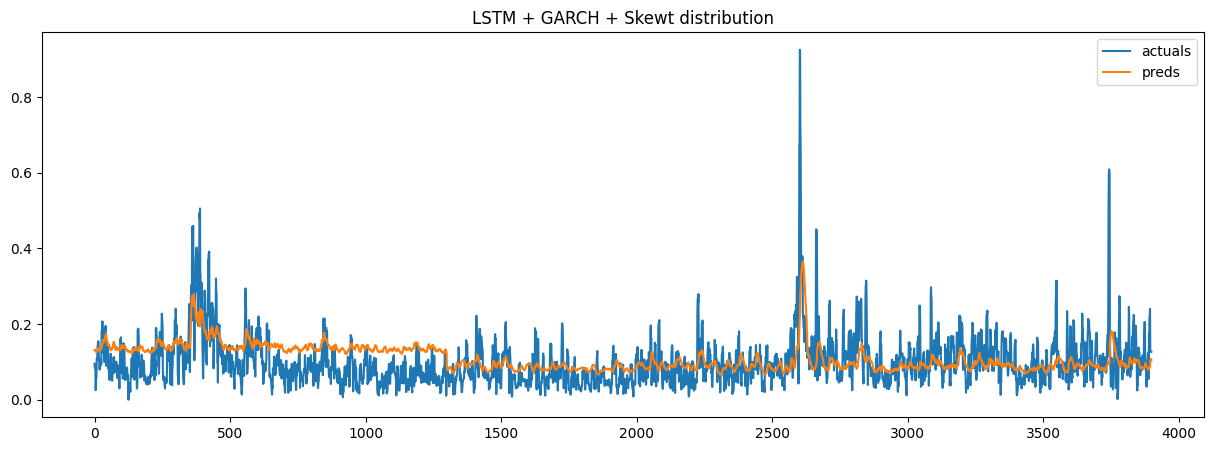

In [ ]:
all_test_preds=GARCH_skewt_preds_actuals[2]
all_test_actuals=GARCH_skewt_preds_actuals[3]

plt.figure(figsize=(15,5))
plt.plot(all_test_actuals,label='actuals')
plt.plot(all_test_preds,label='preds')
plt.legend()
plt.title('LSTM + GARCH + Skewt distribution')
plt.show()

# Model : (GARCH + normal) + LSTM

In [ ]:
GARCH_norm_metric, GARCH_norm_preds_actuals=walk_forward_validation(windowed_data_GARCH_norm_params,Y)

train-> 0 : 2387, test-> 2387 : 3687
train-> 1300 : 3687, test-> 3687 : 4987
train-> 2600 : 4987, test-> 4987 : 6287
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


In [ ]:
save_preds_actuals(tup=GARCH_norm_preds_actuals,
                   model_name='GARCH',
                   dist_name='norm')

data saved!


In [ ]:
print('Train')
print(GARCH_norm_metric['train_MSE'])
print('Mean of MSEs : ',np.array(GARCH_norm_metric['train_MSE']).mean())
print('------------------------------------------------------------------')
print('Test')
print(GARCH_norm_metric['test_MSE'])
print('Mean of MSEs : ',np.array(GARCH_norm_metric['test_MSE']).mean())

Train
[0.006960037182205309, 0.010218624092524383, 0.0035592823818570386]
Mean of MSEs :  0.006912647885528911
------------------------------------------------------------------
Test
[0.003907680638793688, 0.00189733004611477, 0.008088712528241164]
Mean of MSEs :  0.004631241071049875


In [ ]:
print('Train')
print(GARCH_norm_metric['train_MAE'])
print('Mean of MAEs : ',np.array(GARCH_norm_metric['train_MAE']).mean())
print('------------------------------------------------------------------')
print('Test')
print(GARCH_norm_metric['test_MAE'])
print('Mean of MAEs : ',np.array(GARCH_norm_metric['test_MAE']).mean())

Train
[0.059151099764762106, 0.06184950131139189, 0.038940654434792214]
Mean of MAEs :  0.053313751836982066
------------------------------------------------------------------
Test
[0.05202993926232035, 0.033410638576588714, 0.0581976258811578]
Mean of MAEs :  0.04787940124002229


In [ ]:
print('Train')
print(GARCH_norm_metric['train_RMSE'])
print('Mean of RMSEs : ',np.array(GARCH_norm_metric['train_RMSE']).mean())
print('------------------------------------------------------------------')
print('Test')
print(GARCH_norm_metric['test_RMSE'])
print('Mean of RMSEs : ',np.array(GARCH_norm_metric['test_RMSE']).mean())

Train
[0.08342683730194564, 0.10108721033110164, 0.059659721603918324]
Mean of RMSEs :  0.08139125641232188
------------------------------------------------------------------
Test
[0.06251144406261695, 0.043558352196964134, 0.08993726996213063]
Mean of RMSEs :  0.06533568874057057


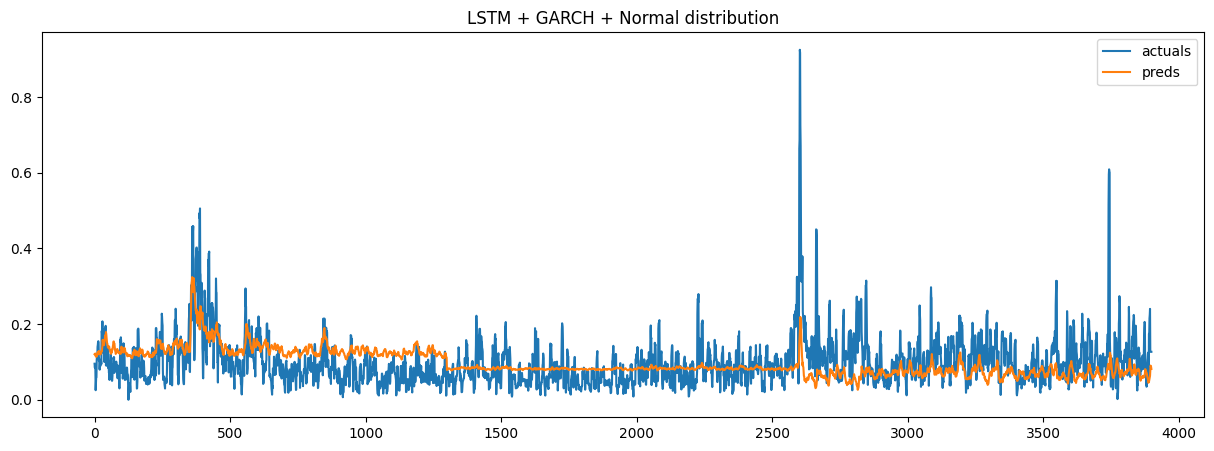

In [ ]:
all_test_preds=GARCH_norm_preds_actuals[2]
all_test_actuals=GARCH_norm_preds_actuals[3]

plt.figure(figsize=(15,5))
plt.plot(all_test_actuals,label='actuals')
plt.plot(all_test_preds,label='preds')
plt.legend()
plt.title('LSTM + GARCH + Normal distribution')
plt.show()

# (GARCH + all_dist) + LSTM

In [ ]:
GARCH_all_dist_metric, GARCH_all_dist_preds_actuals=walk_forward_validation(windowed_data_GARCH_all_dist,Y)

train-> 0 : 2387, test-> 2387 : 3687
train-> 1300 : 3687, test-> 3687 : 4987
train-> 2600 : 4987, test-> 4987 : 6287
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [ ]:
save_preds_actuals(tup=GARCH_all_dist_preds_actuals,
                   model_name='GARCH',
                   dist_name='all_dist')

data saved!


In [ ]:
print('Train')
print(GARCH_all_dist_metric['train_MSE'])
print('Mean of MSEs : ',np.array(GARCH_all_dist_metric['train_MSE']).mean())
print('------------------------------------------------------------------')
print('Test')
print(GARCH_all_dist_metric['test_MSE'])
print('Mean of MSEs : ',np.array(GARCH_all_dist_metric['test_MSE']).mean())

Train
[0.007367132489791595, 0.009212043308229423, 0.0026134040705218975]
Mean of MSEs :  0.006397526622847639
------------------------------------------------------------------
Test
[0.004684643770925456, 0.0022170955622720753, 0.00578296318182212]
Mean of MSEs :  0.004228234171673217


In [ ]:
print('Train')
print(GARCH_all_dist_metric['train_MAE'])
print('Mean of MAEs : ',np.array(GARCH_all_dist_metric['train_MAE']).mean())
print('------------------------------------------------------------------')
print('Test')
print(GARCH_all_dist_metric['test_MAE'])
print('Mean of MAEs : ',np.array(GARCH_all_dist_metric['test_MAE']).mean())

Train
[0.061726860973260626, 0.05965332042265113, 0.036185116701076506]
Mean of MAEs :  0.05252176603232942
------------------------------------------------------------------
Test
[0.05783250250917464, 0.0382565073328742, 0.0468627520502386]
Mean of MAEs :  0.04765058729742915


In [ ]:
print('Train')
print(GARCH_all_dist_metric['train_RMSE'])
print('Mean of RMSEs : ',np.array(GARCH_all_dist_metric['train_RMSE']).mean())
print('------------------------------------------------------------------')
print('Test')
print(GARCH_all_dist_metric['test_RMSE'])
print('Mean of RMSEs : ',np.array(GARCH_all_dist_metric['test_RMSE']).mean())

Train
[0.08583200154832459, 0.09597939001801076, 0.05112146389259503]
Mean of RMSEs :  0.07764428515297679
------------------------------------------------------------------
Test
[0.06844445756177381, 0.04708604424107079, 0.07604579660850506]
Mean of RMSEs :  0.06385876613711655


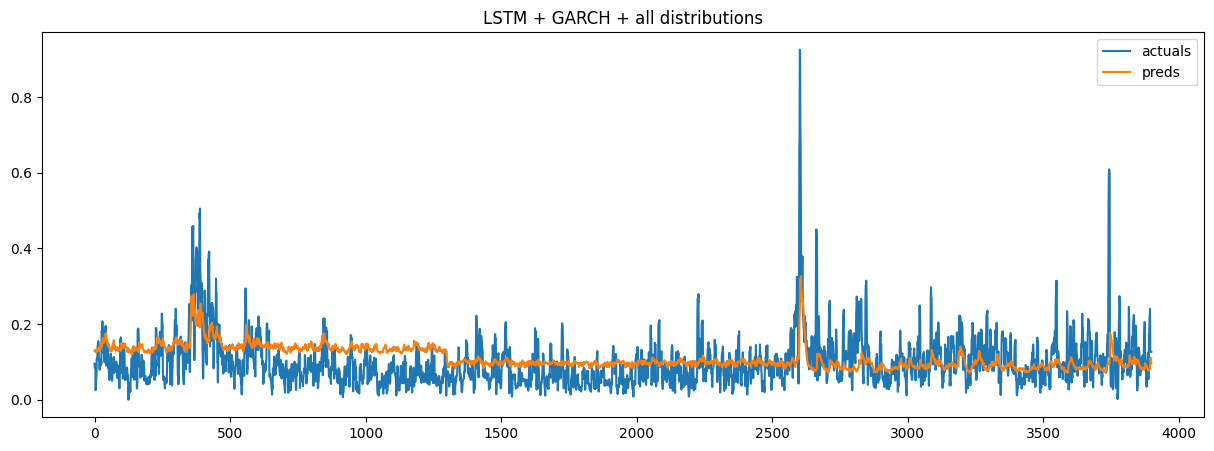

In [ ]:
all_test_preds=GARCH_all_dist_preds_actuals[2]
all_test_actuals=GARCH_all_dist_preds_actuals[3]

plt.figure(figsize=(15,5))
plt.plot(all_test_actuals,label='actuals')
plt.plot(all_test_preds,label='preds')
plt.legend()
plt.title('LSTM + GARCH + all distributions')
plt.show()

# Bar Graphs of metrics

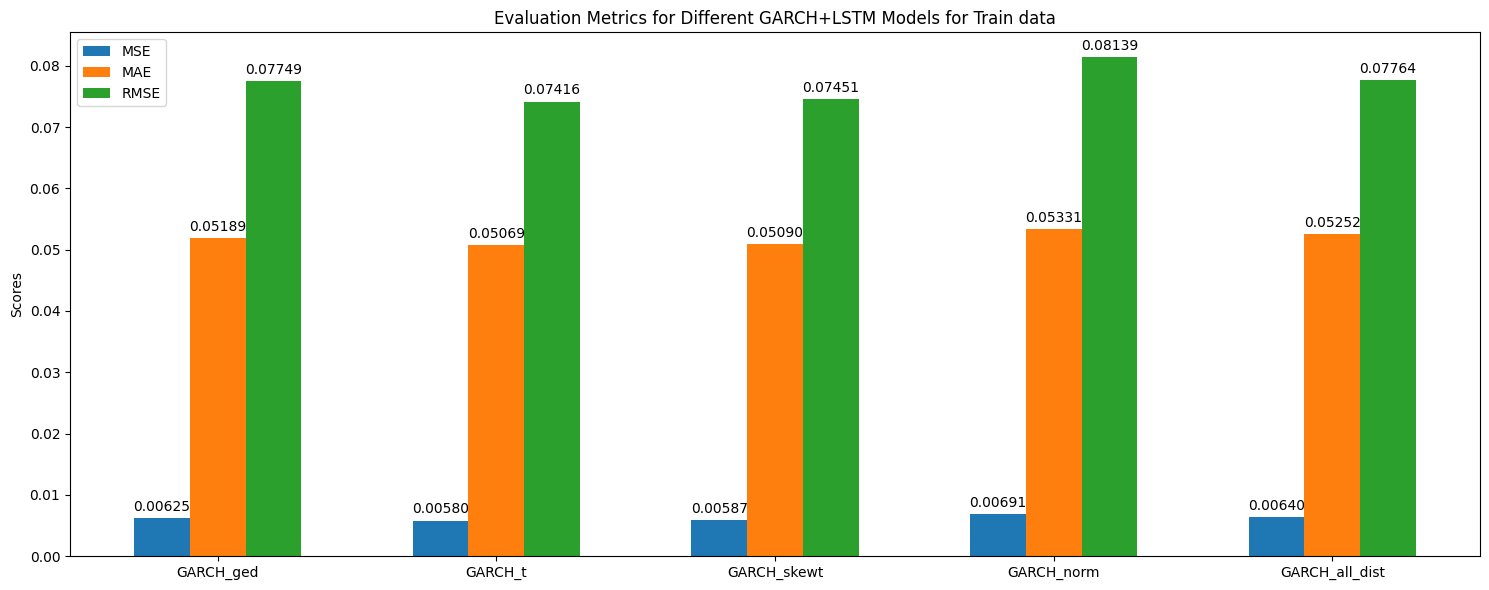

In [ ]:

import matplotlib.pyplot as plt
import numpy as np


models = ['GARCH_ged', 'GARCH_t', 'GARCH_skewt', 'GARCH_norm', 'GARCH_all_dist']
mse_scores = [
    np.array(GARCH_ged_metric['train_MSE']).mean(),
    np.array(GARCH_t_metric['train_MSE']).mean(),
    np.array(GARCH_skewt_metric['train_MSE']).mean(),
    np.array(GARCH_norm_metric['train_MSE']).mean(),
    np.array(GARCH_all_dist_metric['train_MSE']).mean(),
]
mae_scores = [
    np.array(GARCH_ged_metric['train_MAE']).mean(),
    np.array(GARCH_t_metric['train_MAE']).mean(),
    np.array(GARCH_skewt_metric['train_MAE']).mean(),
    np.array(GARCH_norm_metric['train_MAE']).mean(),
    np.array(GARCH_all_dist_metric['train_MAE']).mean(),
]
rmse_scores = [
    np.array(GARCH_ged_metric['train_RMSE']).mean(),
    np.array(GARCH_t_metric['train_RMSE']).mean(),
    np.array(GARCH_skewt_metric['train_RMSE']).mean(),
    np.array(GARCH_norm_metric['train_RMSE']).mean(),
    np.array(GARCH_all_dist_metric['train_RMSE']).mean(),
]

x = np.arange(len(models))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(15, 6))
rects1 = ax.bar(x - width, mse_scores, width, label='MSE')
rects2 = ax.bar(x, mae_scores, width, label='MAE')
rects3 = ax.bar(x + width, rmse_scores, width, label='RMSE')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Evaluation Metrics for Different GARCH+LSTM Models for Train data')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()


def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.5f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()

plt.savefig("Evaluation Metrics for Different GARCH+LSTM Models for Train data.jpg")
plt.show()


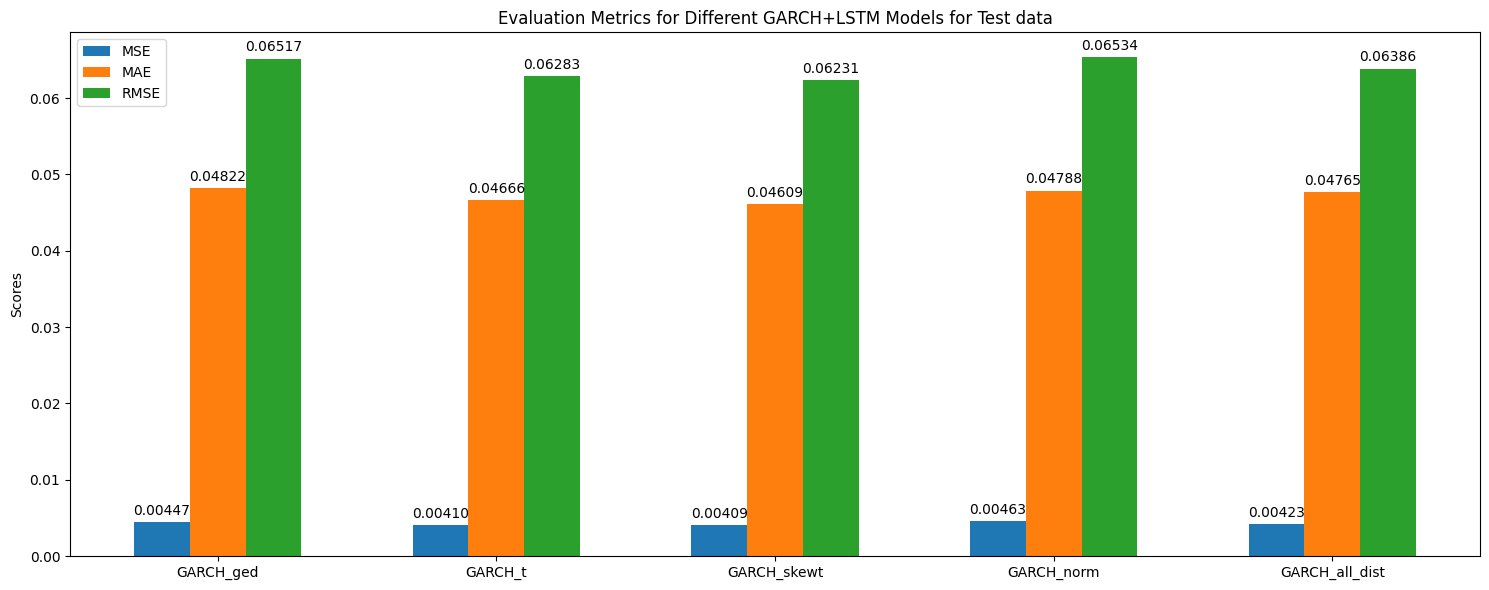

In [ ]:

import matplotlib.pyplot as plt
import numpy as np


models = ['GARCH_ged', 'GARCH_t', 'GARCH_skewt', 'GARCH_norm', 'GARCH_all_dist']
mse_scores = [
    np.array(GARCH_ged_metric['test_MSE']).mean(),
    np.array(GARCH_t_metric['test_MSE']).mean(),
    np.array(GARCH_skewt_metric['test_MSE']).mean(),
    np.array(GARCH_norm_metric['test_MSE']).mean(),
    np.array(GARCH_all_dist_metric['test_MSE']).mean(),
]
mae_scores = [
    np.array(GARCH_ged_metric['test_MAE']).mean(),
    np.array(GARCH_t_metric['test_MAE']).mean(),
    np.array(GARCH_skewt_metric['test_MAE']).mean(),
    np.array(GARCH_norm_metric['test_MAE']).mean(),
    np.array(GARCH_all_dist_metric['test_MAE']).mean(),
]
rmse_scores = [
    np.array(GARCH_ged_metric['test_RMSE']).mean(),
    np.array(GARCH_t_metric['test_RMSE']).mean(),
    np.array(GARCH_skewt_metric['test_RMSE']).mean(),
    np.array(GARCH_norm_metric['test_RMSE']).mean(),
    np.array(GARCH_all_dist_metric['test_RMSE']).mean(),
]

x = np.arange(len(models))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(15, 6))
rects1 = ax.bar(x - width, mse_scores, width, label='MSE')
rects2 = ax.bar(x, mae_scores, width, label='MAE')
rects3 = ax.bar(x + width, rmse_scores, width, label='RMSE')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Evaluation Metrics for Different GARCH+LSTM Models for Test data')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()


def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.5f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()

plt.savefig("Evaluation Metrics for Different GARCH+LSTM Models for Test data.jpg")
plt.show()


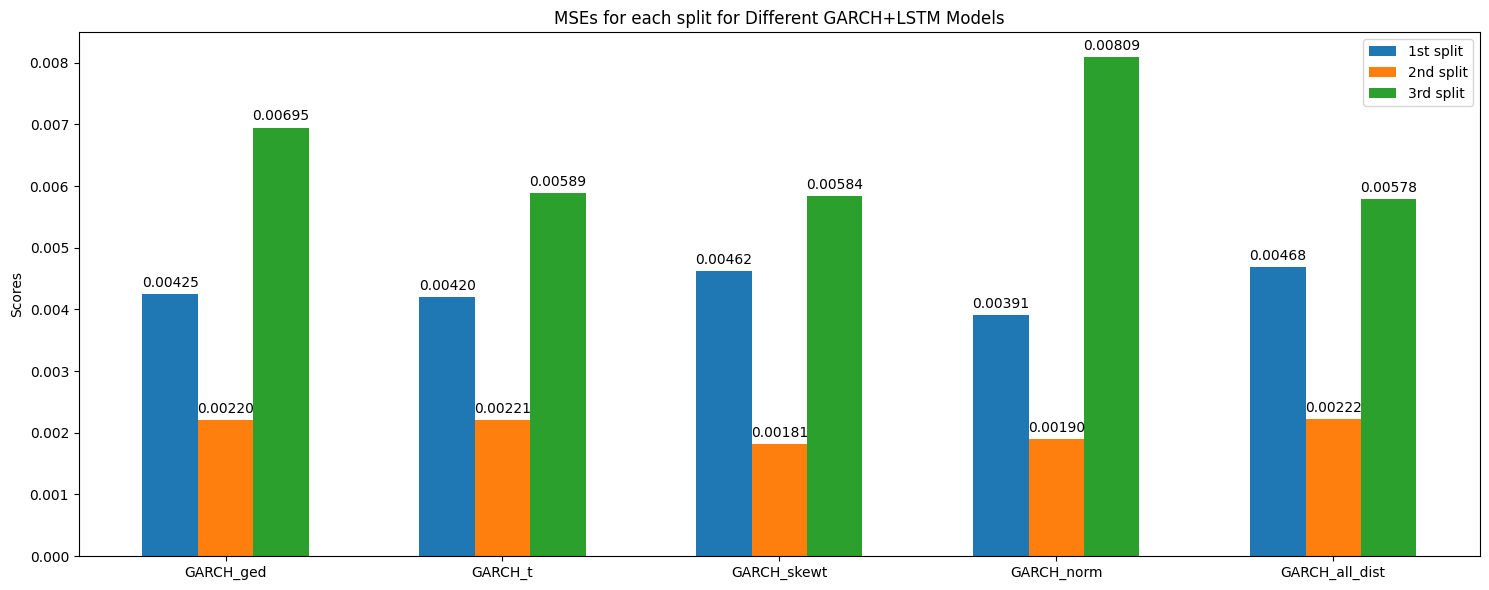

In [ ]:

import matplotlib.pyplot as plt
import numpy as np


models = ['GARCH_ged', 'GARCH_t', 'GARCH_skewt', 'GARCH_norm', 'GARCH_all_dist']
mse_scores_1 = [
    np.array(GARCH_ged_metric['test_MSE'])[0],
    np.array(GARCH_t_metric['test_MSE'])[0],
    np.array(GARCH_skewt_metric['test_MSE'])[0],
    np.array(GARCH_norm_metric['test_MSE'])[0],
    np.array(GARCH_all_dist_metric['test_MSE'])[0],
]
mse_scores_2 = [
    np.array(GARCH_ged_metric['test_MSE'])[1],
    np.array(GARCH_t_metric['test_MSE'])[1],
    np.array(GARCH_skewt_metric['test_MSE'])[1],
    np.array(GARCH_norm_metric['test_MSE'])[1],
    np.array(GARCH_all_dist_metric['test_MSE'])[1],
]
mse_scores_3 = [
    np.array(GARCH_ged_metric['test_MSE'])[2],
    np.array(GARCH_t_metric['test_MSE'])[2],
    np.array(GARCH_skewt_metric['test_MSE'])[2],
    np.array(GARCH_norm_metric['test_MSE'])[2],
    np.array(GARCH_all_dist_metric['test_MSE'])[2],
]

x = np.arange(len(models))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(15, 6))
rects1 = ax.bar(x - width, mse_scores_1, width, label='1st split')
rects2 = ax.bar(x, mse_scores_2, width, label='2nd split')
rects3 = ax.bar(x + width, mse_scores_3, width, label='3rd split')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('MSEs for each split for Different GARCH+LSTM Models')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()


def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.5f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()

plt.savefig("MSEs for each split for Different GARCH+LSTM Models.jpg")
plt.show()


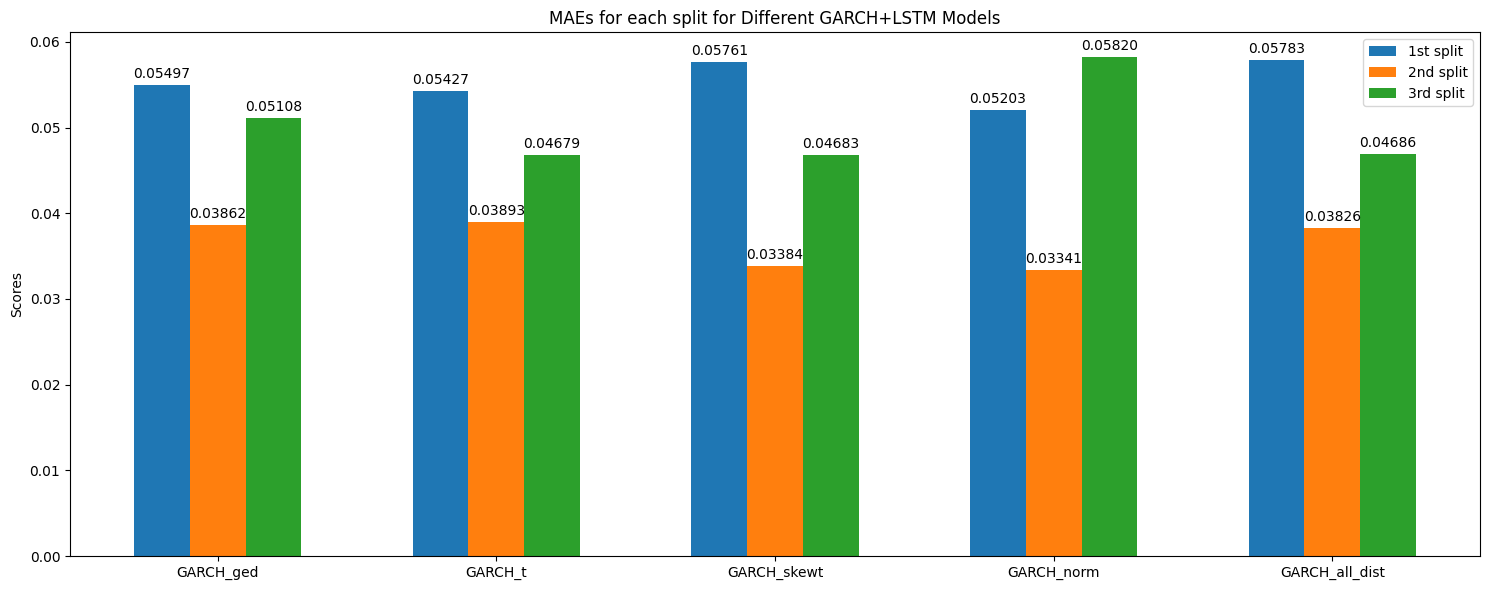

In [ ]:

import matplotlib.pyplot as plt
import numpy as np


models = ['GARCH_ged', 'GARCH_t', 'GARCH_skewt', 'GARCH_norm', 'GARCH_all_dist']
mae_scores_1 = [
    np.array(GARCH_ged_metric['test_MAE'])[0],
    np.array(GARCH_t_metric['test_MAE'])[0],
    np.array(GARCH_skewt_metric['test_MAE'])[0],
    np.array(GARCH_norm_metric['test_MAE'])[0],
    np.array(GARCH_all_dist_metric['test_MAE'])[0],
]
mae_scores_2 = [
    np.array(GARCH_ged_metric['test_MAE'])[1],
    np.array(GARCH_t_metric['test_MAE'])[1],
    np.array(GARCH_skewt_metric['test_MAE'])[1],
    np.array(GARCH_norm_metric['test_MAE'])[1],
    np.array(GARCH_all_dist_metric['test_MAE'])[1],
]
mae_scores_3 = [
    np.array(GARCH_ged_metric['test_MAE'])[2],
    np.array(GARCH_t_metric['test_MAE'])[2],
    np.array(GARCH_skewt_metric['test_MAE'])[2],
    np.array(GARCH_norm_metric['test_MAE'])[2],
    np.array(GARCH_all_dist_metric['test_MAE'])[2],
]

x = np.arange(len(models))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(15, 6))
rects1 = ax.bar(x - width, mae_scores_1, width, label='1st split')
rects2 = ax.bar(x, mae_scores_2, width, label='2nd split')
rects3 = ax.bar(x + width, mae_scores_3, width, label='3rd split')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('MAEs for each split for Different GARCH+LSTM Models')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()


def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.5f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()

plt.savefig("MAEs for each split for Different GARCH+LSTM Models.jpg")
plt.show()


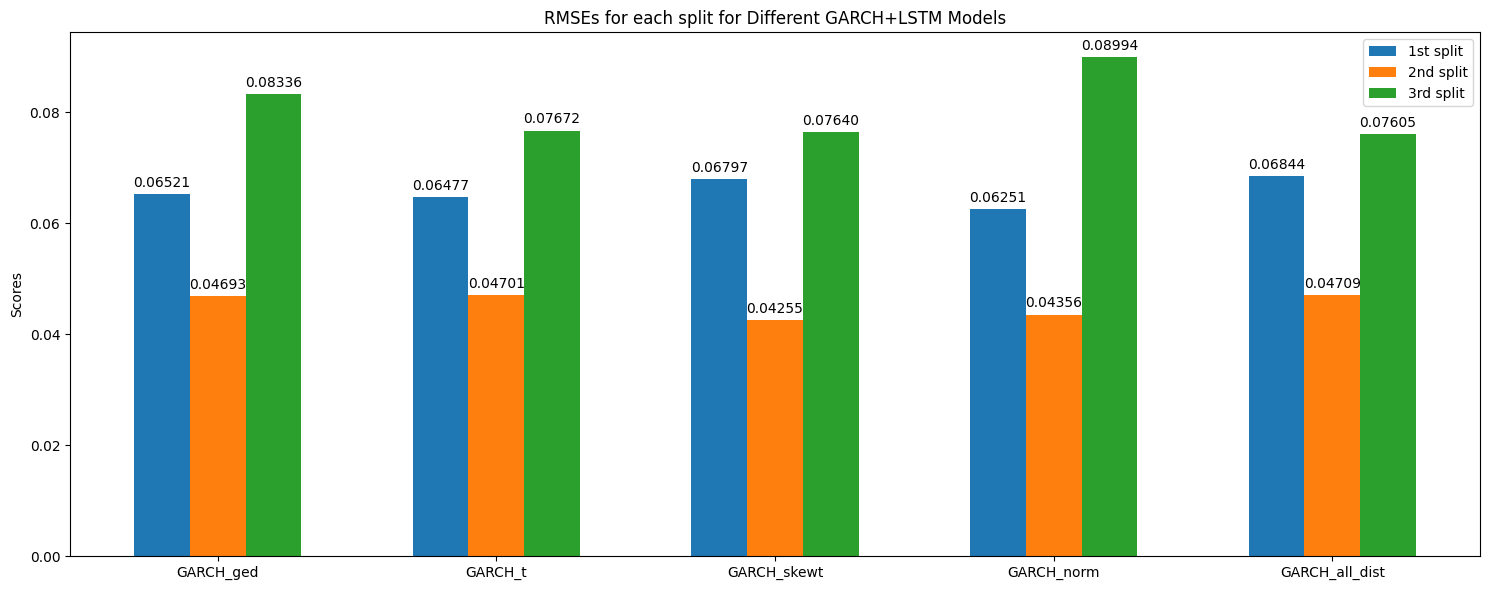

In [ ]:

import matplotlib.pyplot as plt
import numpy as np


models = ['GARCH_ged', 'GARCH_t', 'GARCH_skewt', 'GARCH_norm', 'GARCH_all_dist']
rmse_scores_1 = [
    np.array(GARCH_ged_metric['test_RMSE'])[0],
    np.array(GARCH_t_metric['test_RMSE'])[0],
    np.array(GARCH_skewt_metric['test_RMSE'])[0],
    np.array(GARCH_norm_metric['test_RMSE'])[0],
    np.array(GARCH_all_dist_metric['test_RMSE'])[0],
]
rmse_scores_2 = [
    np.array(GARCH_ged_metric['test_RMSE'])[1],
    np.array(GARCH_t_metric['test_RMSE'])[1],
    np.array(GARCH_skewt_metric['test_RMSE'])[1],
    np.array(GARCH_norm_metric['test_RMSE'])[1],
    np.array(GARCH_all_dist_metric['test_RMSE'])[1],
]
rmse_scores_3 = [
    np.array(GARCH_ged_metric['test_RMSE'])[2],
    np.array(GARCH_t_metric['test_RMSE'])[2],
    np.array(GARCH_skewt_metric['test_RMSE'])[2],
    np.array(GARCH_norm_metric['test_RMSE'])[2],
    np.array(GARCH_all_dist_metric['test_RMSE'])[2],
]

x = np.arange(len(models))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(15, 6))
rects1 = ax.bar(x - width, rmse_scores_1, width, label='1st split')
rects2 = ax.bar(x, rmse_scores_2, width, label='2nd split')
rects3 = ax.bar(x + width, rmse_scores_3, width, label='3rd split')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('RMSEs for each split for Different GARCH+LSTM Models')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()


def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.5f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()

plt.savefig("RMSEs for each split for Different GARCH+LSTM Models.jpg")
plt.show()
